# Problem 1.1

### Phase plot

In [100]:
from scipy.integrate import odeint
from ipywidgets import interact, fixed

import matplotlib.pyplot as plt
import numpy as np

# Define the system provided in the assignment
def system_sir(y, t, beta, gamma):
    S, I, R = y
    return [-beta*S*I, beta*S*I-gamma*I, gamma*I]

# Solve a S.I.R.
def solve_sir(system, S0, I0, t, rates):
    y0 = [S0, I0, 1-S0-I0]  
    sol = odeint(system, y0, t, args=rates)
    return sol

def phase_plot(system, t_model, rates, fig_name):

    # Visual wrap-up
    fig = plt.figure()
    plt.xlabel('Proportionate number of susceptibles $S$')
    plt.ylabel('Proportionate number of infecteds $I$')
    plt.plot([0,1], [0.001, 0.001], c='lightgrey')
    plt.plot([0,1], [1, 0.001], c='lightgrey')
    
    # R0 = 0
    n_steps = 8
    S = np.linspace(0, 1, n_steps)   
    for i in range(n_steps):
        data = solve_sir(system, S[i],1-S[i], t_model, rates)
        plt.plot(S[i], 1-S[i], 'o', c='black')
        plt.plot(data[:,0], data[:,1], c='C0')
        
    # R0 =/= 0
    fixed = rates[1]/rates[0]
    n_steps = 6
    S = np.linspace(fixed, 1, n_steps)
    for i in range(n_steps):
        data = solve_sir(system, S[i], 0.001, t_model, rates)
        plt.plot(S[i], 0.001, 'o', c='black')
        plt.plot(data[:,0], data[:,1], c='C0')
        
    plt.savefig(fig_name)
    
# Helper function to make function phase_plot interactive    
def phase_interactive_sir(beta=3, gamma=1):
    t = np.linspace(0, 30, 1000)
    phase_plot(system_sir, t, (beta, gamma), 'lab1_1_1_phase_plot.png')

interact(phase_interactive_sir, beta=(0, 5.0), gamma=(0, 5.0))

interactive(children=(FloatSlider(value=3.0, description='beta', max=5.0), FloatSlider(value=1.0, description=…

<function __main__.phase_interactive_sir(beta=3, gamma=1)>

Plot S, I and R as a function of time. Make beta and gamma variable

In [2]:
def plot_SIR_vs_time(S0, t_model, beta=1.7, gamma=0.5):
    sol = solve_sir(system_sir, S0, 1-S0, t_model, (beta, gamma))
    R = np.ones(len(t_model)) - sol[:,0] - sol[:,1]
    fig = plt.figure()
    plt.plot(t_model, sol[:,0], label='S')
    plt.plot(t_model, sol[:,1], label='I')
    plt.plot(t_model, R, label='R')
    plt.xlabel('Time in timestep t')
    plt.ylabel('Scaled S, I and R')
    plt.legend()
    plt.savefig('lab1_1_1_SIR_vs_time.png')
    plt.show()
    return 0

t_SIR_vs_time = np.linspace(0,14,141)
#plot_SIR_vs_time(0.5, t_SIR_vs_time)
interact(plot_SIR_vs_time, S0=fixed(0.8), t_model=fixed(t_SIR_vs_time), beta=(0, 5.0), gamma=(0, 5.0))

interactive(children=(FloatSlider(value=1.7, description='beta', max=5.0), FloatSlider(value=0.5, description=…

<function __main__.plot_SIR_vs_time(S0, t_model, beta=1.7, gamma=0.5)>

# Problem 1.2

Plot model, model points and datapoints

In [3]:
# Load (i.e. manually type in) data provided in the assignment
def load_data():
    t_data = list(range(1, 15))
    I = np.array([3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5])/763
    return np.array([t_data, I])

# Plot the SIR-model
def plot_model(sol, t_model):
    plt.plot(t_model, sol[:,1], label='I model')
    return 0

# Plot the predictions made by the model at the timesteps provided by the sample
def plot_model_points(sol, t_model, t_data):
    index_list = [np.argmax(t_model>=x) for  x in t_data]
    x_model_points = [t_model[x] for x in index_list]
    y_model_points = [sol[:,1][x] for x in index_list]
    plt.scatter(x_model_points, y_model_points)
    return 0
    
# Plot the data from 1.2
def plot_data(data):
    plt.scatter(data[0], data[1], label='I sample data', zorder=1)
    return 0
    
# Plot a figure which displays the predicted number of infecteds and the number of infecteds in the sample
def plot_figure(S0, t_model, beta=1.7, gamma=0.5):
    
    # Load and calculate data/results, initialize figure
    data = load_data()
    sol = solve_sir(system_sir, S0, 1-S0, t_model, (beta, gamma))
    fig = plt.figure()
    
    # Plot results
    plot_model(sol, t_model)
    plot_model_points(sol, t_model, data[0])
    plot_data(data)
    
    # Label axis and show plot
    plt.xlabel('Time, t')
    plt.ylabel('Number of infecteds scaled to population size, I')
    plt.legend()
    plt.savefig('lab_1_1_2_influenza_fit.png')
    plt.show()
    return 0

# Initialize problem-specific values, create interactive plot
S0_influenza = 1 - 1/763
t_influenza = np.linspace(0,14,141)
interact(plot_figure, S0=fixed(S0_influenza), t_model=fixed(t_influenza), beta=(0, 5.0), gamma=(0, 5.0))

interactive(children=(FloatSlider(value=1.7, description='beta', max=5.0), FloatSlider(value=0.5, description=…

<function __main__.plot_figure(S0, t_model, beta=1.7, gamma=0.5)>

### Fitting

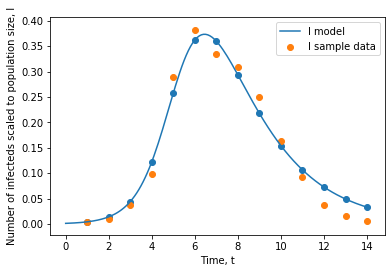

0

In [4]:
# Calculate the RMSE between y1 and y2
def get_rmse(y1, y2):
    n_points = list(range(len(y1)))
    return np.sqrt(np.array([((y1[i] - y2[i]) ** 2) for i in n_points]).mean())

# Given a beta, gamma and a set of data, calculate the score
def get_model_score(model, data, S0, t_model, index_list):
    I = solve_sir(system_sir, S0, 1-S0, t_model, (model[0], model[1]))[:,1]
    model_points = [I[index] for index in index_list]
    mse = get_rmse(model_points, data[1])
    return mse

# Find the best model (i.e. beta-gamma combination that scores the highest)
def get_best_model(models, data, S0, t_model):  
    t_data = data[0]
    index_list = [np.argmax(t_model>=x) for  x in t_data]
    scores = [get_model_score(model, data, S0, t_model, index_list) for model in models]
    best_model = models[np.argmin(scores)]
    return best_model

# Generate a variety of possible beta-gamma combinations
def get_beta_gamma():
    models = []
    for beta in np.arange(1, 2, 0.05):
        for gamma in np.arange(0, 1, 0.05):
            models.append([beta, gamma])
    return np.array(models)

# Find the best values for beta and gamma. That is, values that best fit the data from the sample
def find_best_fit(t_model, S0):
    data = load_data()
    models = get_beta_gamma()
    t_model = np.linspace(0, 14, 141)
    best_model = get_best_model(models, data, S0, t_model)
    return best_model

# Initialize problem-specific values, find best beta-gamma combination based on MSE
t_influenza = np.linspace(0, 14, 141)
S0_influenza = 1 - 1/763
best_model = find_best_fit(t_influenza, S0_influenza)

# Plot figure with the original data, and the model corresponding to the best beta-gamma combination
title_influenza = 'Model with minimized MSE, with beta={:1.2f}, gamma={:1.2f}'.format(best_model[0], best_model[1])
plot_figure(S0_influenza, t_influenza, best_model[0], best_model[1])

# Problem 1.3

# Problem 2.1

Interactive phase plot for a SIR model with demographics

In [5]:
import ipywidgets as widgets

# Define a new system of ODE's 
def system_demographic(y, t, beta, gamma, mu):
    S, I, R = y
    return [mu - beta*S*I - mu*S, beta*S*I - gamma*I - mu*I, gamma*I - mu*R]
    
# Recycle the function phase_plot and make it interactive
def phase_interact(beta=3, gamma=1, mu=0.01):
    t = np.linspace(0, 50, 1000)
    system_name = system_demographic
    phase_plot(system_name, t, (beta, gamma, mu), 'lab_1_2_1_phase.png')
    return 0

fig_name_SIR_demographic = 'lab1_2_1_phase.png'
interact(phase_interact, beta=(0, 5.0), gamma=(0, 5.0), 
         mu=widgets.FloatSlider(min=1/100, max=1, step=0.001, value=0.0125))

interactive(children=(FloatSlider(value=3.0, description='beta', max=5.0), FloatSlider(value=1.0, description=…

<function __main__.phase_interact(beta=3, gamma=1, mu=0.01)>

Plot that shows S, I and R as a function of time

39.863120569757726
0.008179012345679013


0

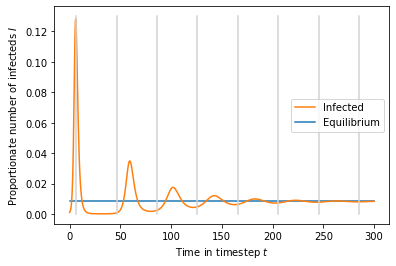

In [150]:
def calc_fixed_I(beta, gamma, mu):
    R0 = calc_R0(beta, gamma, mu)
    return (mu/beta)*(R0-1)

def calc_G(gamma, mu):
    return 1/(mu + gamma)

def calc_A(beta, gamma, mu):
    R0 = calc_R0(beta, gamma, mu)
    return 1/(mu*(R0-1))

def calc_R0(beta, gamma, mu):
    return beta/(gamma+mu)

def calc_S_star(beta, gamma, mu):
    R0 = calc_R0(beta, gamma, mu)
    return 1/(calc_R0(beta, gamma, mu))

def calc_I_star(beta, gamma, mu):
    R0 = calc_R0(beta, gamma, mu)
    return ((mu*R0)/beta)-(mu/beta)

def get_SIR_values_demographic(t, S0, rates):
    sol = solve_sir(system_demographic, S0, 0.001, t, rates)
    return [sol[:,0], sol[:,1], 1 - sol[:,0] - sol[:,1]]

def calc_period(beta, gamma, mu):
    return 2*np.pi*np.sqrt(calc_A(beta, gamma, mu)*calc_G(gamma, mu))

# Find the first peak by searching for the first value that is smaller than its predecessor
def find_first_peak(dXdt, t):
    last_val = -1
    for i in range(len(dXdt)):
        if dXdt[i] < last_val: return t[i]
        else: last_val = dXdt[i]
    return

def plot_SIR_demographic(t, S0, rates):
    data = get_SIR_values_demographic(t, S0, rates)
    peak_I = find_first_peak(data[1], t)
    fig = plt.figure()
    period = calc_period(beta, gamma, mu)
    print(period)
    plt.plot(t, data[1], label='Infected', c='C1')
    for i in range(8):
        plt.plot([peak_I + i*period, peak_I + i*period], [0, 0.13], c='lightgrey')
    fixed = calc_fixed_I(beta, gamma, mu)
    print(fixed)
    plt.plot([t[0], t[-1]], [fixed, fixed], zorder=0, label='Equilibrium')
    plt.xlabel('Time in timestep $t$')
    plt.ylabel('Proportionate number of infecteds $I$')
    plt.legend()
    plt.savefig('lab_4_2_1_I_vs_time.png')
    return 0

beta=3; gamma=1; mu=0.0125
plot_SIR_demographic(np.linspace(0, 300, 1000), 0.7, (beta, gamma, mu))

In [7]:
def plot_SIR_demographic_interact(t, S0=0.8, beta=1, gamma=0.333, mu=0.016):
    print("S0={}, beta={}, gamma={}, mu={}".format(S0, beta, gamma, mu))
    plot_SIR_demographic(t, S0, (beta, gamma, mu))
    period = calc_period(beta, gamma, mu)
    print(period)
    plt.xlabel('Time in timestep $t$')
    plt.ylabel('Proportionate number of infecteds $I$')
    # print("A={}".format(calc_A(beta, gamma, mu)))
    # print("G={}".format(calc_G(gamma, mu)))
    plt.savefig('lab1_2_1_I_vs_t.png')
    plt.show()

t_model = np.linspace(50, 400 , 1000)

interact(plot_SIR_demographic_interact, t=fixed(t_model), S0=(0,1.0), beta=(1, 5.0), gamma=(0, 5.0), 
         mu=widgets.FloatSlider(min=0.01, max=0.02, step=0.001, value=0.0125))

interactive(children=(FloatSlider(value=0.8, description='S0', max=1.0), FloatSlider(value=1.0, description='b…

<function __main__.plot_SIR_demographic_interact(t, S0=0.8, beta=1, gamma=0.333, mu=0.016)>

# Problem 2.2: Adding infection induced mortality

SIR model with demography and infection induced mortality. Plot that shows S, I and R as a function of time. This plot is used in the lab report

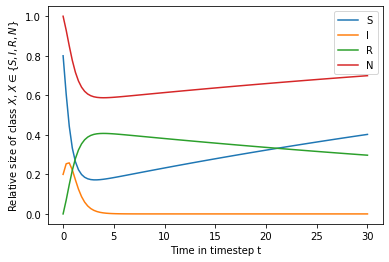

0

In [49]:
# Define SIR system with demography and infection induced mortality
def system_mortality(y, t, beta, gamma, mu, rho):
    S, I, R = y
    dSdt = mu - beta*S*I - mu*S
    dIdt = beta*S*I - ((gamma + mu)/(1 - rho))*I
    dRdt = gamma*I - mu*R
    return [dSdt, dIdt, dRdt]

# Solve SIR system with demography and infection induced mortality
def solve_system_mortality(system_name, y0, t, rates):
    solution = odeint(system_name, y0, t, args=rates)
    return solution

# Plot S, I and R over time. First line test if total population equals 1
def plot_system_mortality(system_name, y0, t, rates):
    if 1 == np.array(y0).sum():
        fig = plt.figure()
        solution = solve_system_mortality(system_name, y0, t, rates)
        population = solution[:,0] + solution[:,1] + solution[:,2]
        plt.plot(t, solution[:,0], label='S')
        plt.plot(t, solution[:,1], label='I')
        plt.plot(t, solution[:,2], label='R')
        plt.plot(t, population, label='N')
        plt.xlabel('Time in timestep t')
        plt.ylabel('Relative size of class $X$, $X\in\{S, I, R, N\}$')
        plt.legend()
        plt.savefig('lab_4_3_1_N_not_constant.png')
        plt.show()
        return 0
    return 1
    
y0 = [0.8, 0.2, 0]
rates = (4, 1, 0.0125, 0.5)
plot_system_mortality(system_mortality, y0, np.linspace(0, 30, 100), rates)

[remove] Interactive figure that shows S, I and R as a function of time. Every parameter is fixed except $\rho$.

In [54]:
# Helper function to make 'plot_system_mortality' interactive
def interact_system_mortality(rho):
    y0 = [0.8, 0.001, 0.199]
    rates = (10, 1, 0.0125, rho)
    plot_system_mortality(system_mortality, y0, np.linspace(0, 50, 1000), rates)  
    return 0

interact(interact_system_mortality, rho=(0,0.99))

interactive(children=(FloatSlider(value=0.495, description='rho', max=0.99), Output()), _dom_classes=('widget-…

<function __main__.interact_system_mortality(rho)>

Plot $I$ vs a selection of different $\rho$ values to show that $\R_0 declines

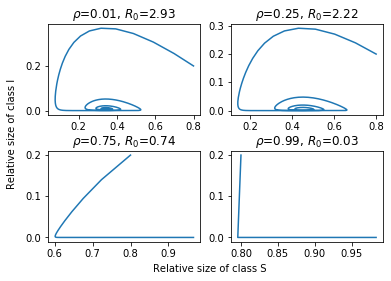

0

In [119]:
def calc_R0_mortality(beta, gamma, mu, rho):
    return (beta*(1-rho))/(mu+gamma)

# Plot four phase plots for different rho values. Note: rates = (beta, gamma, mu)
def plot_I_vs_rho(system_name, y0, t, rates):
    beta, gamma, mu = rates
    avg_infected = []
    rho_vals = [[0.01, 0.25], [0.75, 0.99]]
    fig, ax = plt.subplots(2, 2)
    fig.text(0.5, 0.02, 'Relative size of class S', ha='center')
    fig.text(0.03, 0.5, 'Relative size of class I', va='center', rotation='vertical')
    fig.subplots_adjust(hspace=0.4)
    for i in range(2):
        for j in range(2):
            rho = rho_vals[i][j]
            sol = solve_system_mortality(system_name, y0, t, (beta, gamma, mu, rho))
            R0 = calc_R0_mortality(beta, gamma, mu, rho)
            ax[i][j].plot(sol[:,0], sol[:,1])
            ax[i][j].set_title(r'$\rho$={}, $R_0$={:1.2f}'.format(rho_vals[i][j], R0))
            
    plt.savefig('lab_4_3_1_rho_vs_I.png')
    plt.show()
    return 0
 
y0 = [0.8, 0.2, 0]
rates = (3, 1, 0.0125)
plot_I_vs_rho(system_mortality, y0, np.linspace(0, 200, 1000), rates)



Plot $R_0$ as a function of $\rho$ in order to show that $R_0$ approaches 0 as $\rho$ approaches 1

In [10]:
# Recycled function, repeated here for clarity
def calc_R0(beta, gamma, mu):
    return beta/(gamma+mu)

# Note that the rates parameter does not include rho in this case
def find_R0_values(y0, t, rates):
    beta, gamma, mu = rates
    R0_values = [calc_R0(beta, gamma, mu) for rho in np.arange(0, 1, 0.01)]
    

    
y0 = [0.8, 0.2, 0]
rates = (3, 1, 0.0125)
t = np.linspace(0, 300, 1000)
find_R0_values(y0, t, rates)

# Problem 3: SEIR and forcing

[not used in lab report] SEIR model without seasononality. Simple plot.

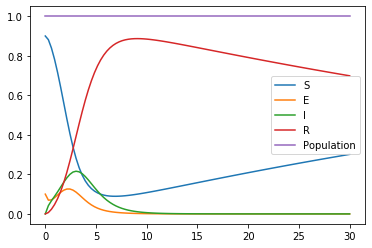

0

In [11]:
def system_SEIR(y, t, beta, gamma, sigma, mu):
    S, E, I, R = y
    dSdt = mu - (beta*I + mu)*S
    dEdt = beta*S*I - (mu + sigma)*E
    dIdt = sigma*E - (mu +gamma)*I
    dRdt = gamma*I - mu*R
    return [dSdt, dEdt, dIdt, dRdt]

# y0 is a list containing [S0, E0, I0, R0]
# rates is a tuple containing (beta, gamma, sigma, mu)
def solve_system_SEIR(system_name, t, y0, rates):
    return odeint(system_name, y0, t, args=rates)
    
def plot_system_SEIR(system_name, t, y0, rates):
    solution = solve_system_SEIR(system_name, t, y0, rates)
    plt.plot(t, solution[:,0], label='S')
    plt.plot(t, solution[:,1], label='E')
    plt.plot(t, solution[:,2], label='I')
    plt.plot(t, solution[:,3], label='R')
    plt.legend()
    plt.show()
    return 0
    
plot_system_SEIR(system_SEIR, np.linspace(0, 30, 100), [0.9, 0.1, 0, 0], (3, 1, 2, 0.0125))

[not used in lab report] Interactive plot to understand the behaviour of function $\beta(t)=\beta_0*(1+\beta_1*\cos (\omega*t)$

In [12]:
# Calculate beta
def calc_beta(t, beta_0, beta_1, omega):
    return beta_0 * (1 + beta_1*np.cos(omega*t))

# Plot a figure with the value of beta vs time
def plot_beta_forcing(t_model, beta_0, beta_1, omega):
    fig = plt.figure(figsize=(15,6))
    beta = [calc_beta(t, beta_0, beta_1, omega) for t in t_model]
    plt.plot(t_model, beta)
    plt.plot([0, 1], [10, 10])
    plt.show()
    
# Helper function to make 'plot_beta_forcing' interactive
def interact_plot_beta_forcing(beta_0, beta_1, omega):
    t_model = np.linspace(0, 300, 1000)
    plot_beta_forcing(t_model, beta_0, beta_1, omega)

interact(interact_plot_beta_forcing, beta_0=(1,5.0), beta_1=(0.01, 0.99), omega=(0, 1.0))

interactive(children=(FloatSlider(value=3.0, description='beta_0', max=5.0, min=1.0), FloatSlider(value=0.5, d…

<function __main__.interact_plot_beta_forcing(beta_0, beta_1, omega)>

SIR model with demography and forcing

In [153]:
# Define the system provided in the assignment
def system_SIR_forcing(y, t, beta_0, beta_1, omega, gamma, mu):
    S, I, R = y
    beta = beta_0*(1 + beta_1*np.cos(omega*t))
    return [mu - beta*S*I - mu*S, beta*S*I - gamma*I - mu*I, gamma*I - mu*R]

# Solve a SIR with forcing
def solve_SIR_forcing(system_name, t, y0, rates):
    return odeint(system_name, y0, t, args=rates)

def plot_SIR_forcing(system_name, t, y0, rates):
    fig = plt.figure()
    solution = solve_SIR_forcing(system_name, t, y0, rates)
    plt.plot(t, solution[:,0], label='S')
    plt.plot(t, solution[:,1], label='I')
    plt.plot(t, solution[:,2], label='R')
    plt.xlabel('Time, t')
    plt.ylabel('Proportionate class size')
    plt.legend()
    plt.savefig('lab_results_forcing.png')
    plt.show()
    return 0

def interact_plot_SIR_forcing(beta_0=2.2, beta_1=0.25, omega=0.05):
    t = np.linspace(0, 600, 1000)
    y0 = [0.8, 0.2, 0]
    rates = (beta_0, beta_1, omega, 1, 0.0125)
    plot_SIR_forcing(system_SIR_forcing, t, y0, rates)
    return 0

interact(interact_plot_SIR_forcing, beta_0=(0,5.0), beta_1=(0.05, 0.55), omega=(0.05, 0.55))

interactive(children=(FloatSlider(value=2.2, description='beta_0', max=5.0), FloatSlider(value=0.25, descripti…

<function __main__.interact_plot_SIR_forcing(beta_0=2.2, beta_1=0.25, omega=0.05)>

SEIR model with forcing. Simple plot

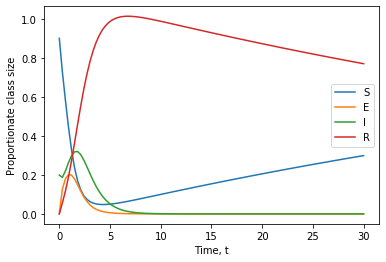

0

In [166]:
def system_SEIR_forcing(y, t, beta_0, beta_1, omega, gamma, sigma, mu):
    S, E, I, R = y
    beta = beta_0*(1 + beta_1*np.cos(omega*t))
    dSdt = mu - (beta*I + mu)*S
    dEdt = beta*S*I - (mu + sigma)*E
    dIdt = sigma*E - (mu +gamma)*I
    dRdt = gamma*I - mu*R
    return [dSdt, dEdt, dIdt, dRdt]

# y0 is a list containing [S0, E0, I0, R0]
# rates is a tuple containing (beta, gamma, sigma, mu)
def solve_system_SEIR_forcing(system_name, t, y0, rates):
    return odeint(system_name, y0, t, args=rates)

def plot_system_SEIR_forcing(system_name, t, y0, rates):
    fig = plt.figure()
    solution = solve_system_SEIR_forcing(system_name, t, y0, rates)
    plt.plot(t, solution[:,0], label='S')
    plt.plot(t, solution[:,1], label='E')
    plt.plot(t, solution[:,2], label='I')
    plt.plot(t, solution[:,3], label='R')
    plt.xlabel('Time, t')
    plt.ylabel('Proportionate class size')
    plt.legend()
    plt.savefig('lab_results_SEIR.png')
    plt.show()
    return 0

beta_0 = 2.5; beta_1 = 0.5; omega = 0.3; gamma = 1; sigma = 2; mu = 0.0125
rates = (beta_0, beta_1, omega, gamma, sigma, mu)

S0 = 0.9; E0 = 0.001; I0 = 0.199; R0 = 0
y0 = [S0, E0, I0, R0]

plot_system_SEIR_forcing(system_SEIR_forcing, np.linspace(0, 30, 100), y0, rates)

Interactive SEIR model with seasonality. Average transmission rate $\beta_0$, seasonality period $\beta_1$ and forcing period $\omega$ are variable.

In [157]:
# Helper function to make 'plot_system_SEIR' interactive
def interact_plot_system_SEIR_forcing(beta_0=2.5, beta_1=0.5, omega=0.3):
    gamma = 1; sigma = 2; mu = 0.0125
    rates = (beta_0, beta_1, omega, gamma, sigma, mu)
    
    S0 = 0.9; E0 = 0.001; I0 = 0; R0 = 0
    classes = [S0, E0, I0, R0]
    
    plot_system_SEIR_forcing(system_SEIR_forcing, np.linspace(0, 600, 1000), classes, rates)
    return 0

interact(interact_plot_system_SEIR_forcing, beta_0=(0, 5.0), beta_1=(0.01, 0.99), omega=(0,1.0))

interactive(children=(FloatSlider(value=2.5, description='beta_0', max=5.0), FloatSlider(value=0.5, descriptio…

<function __main__.interact_plot_system_SEIR_forcing(beta_0=2.5, beta_1=0.5, omega=0.3)>